In [1]:
import os
import pandas as pd
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
from Bio import SeqIO, AlignIO
#from Bio import AlignIO   #, Align
#import shutil
#from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, NodeStyle, TextFace, AttrFace

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
divyeast_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/diverse_yeast')
y1000plus_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools/data') + os.sep
genomes_dir = os.path.normpath('G:/My Drive/Crick_LMS/external_data/genomes')

In [2]:
#Plot Nielsen Lab Selection Calculations vs orthogroup conservation

#Load main analysis file
#struct_analysis = pickle.load(open(base_dir + os.sep + os.path.normpath('Output/data/Filter_clusters.pkl'), 'rb'))
struct_analysis = pickle.load(open(base_dir + os.sep + os.path.normpath('Output/data/Analysis_new_02.pkl'), 'rb'))

params_to_plot = ['Mean(Mapping rate)', 'Mean(Conservation rate AA)', 'Mean(Conservation rate Type)']

struct_data_to_plot = {}

for jj, (og_ref, struct_data) in enumerate(struct_analysis.items()): 
    og = og_ref.split('_')[0]
    struct_data_og = []
    for param in params_to_plot:
        struct_data_og.append(struct_data[param])
    struct_data_to_plot[jj] = [og, og_ref] + struct_data_og 
    
struct_data_to_plot_df = pd.DataFrame.from_dict(struct_data_to_plot, orient='index', columns = ['og', 'og_ref'] + params_to_plot )

#Load Nielsen Lab files 

dnds_nl_with_SCE = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_OG_with_SCE.csv'), index_col=0)
dnds_nl_with_SCE['og'] = [og_label.split('.')[0] for og_label in dnds_nl_with_SCE['OG']]


dnds_nl_03_02 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_03_02.csv'), index_col=0)
dnds_nl_03_02['og'] =  [og_label.split('.')[0] for og_label in dnds_nl_03_02['OG']]

# G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\from_nielsen_lab
#     gene_dn_ds_OG_with_SCE.csv
#     gene_dn_ds_03_02.csv

struct_data_to_plot_df = struct_data_to_plot_df.merge(dnds_nl_with_SCE, how='left', on='og')
struct_data_to_plot_df.rename(columns= {'dN_dS': 'dN_dS_SCE'}, inplace=True)

struct_data_to_plot_df = struct_data_to_plot_df.merge(dnds_nl_03_02,  suffixes = ("_SCE", "_nl_02_03"), how='left', on='og')
struct_data_to_plot_df.rename(columns= {'dN_dS': 'dN_dS_nl_02_03'}, inplace=True)

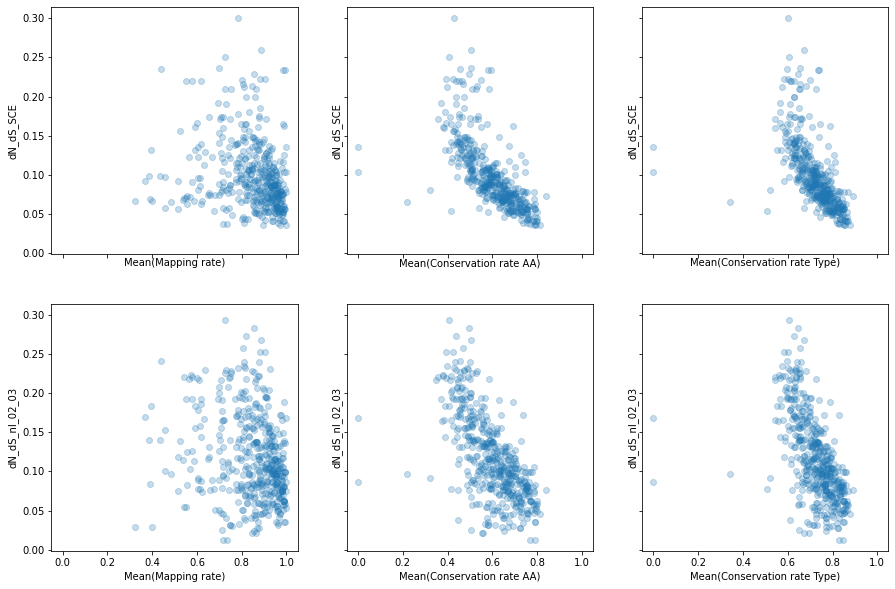

In [3]:
fig, axarr = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey = True)
dnds_cols = [ 'dN_dS_SCE', 'dN_dS_nl_02_03']

for jj, dnds_col in enumerate(dnds_cols):
    for kk, param_to_plot in enumerate(params_to_plot):
        ax = axarr[jj][kk]
        ax.scatter(struct_data_to_plot_df[param_to_plot], struct_data_to_plot_df[dnds_col], alpha = 0.25)
        ax.set_ylabel(dnds_col)
        ax.set_xlabel(param_to_plot)



In [103]:
struct_data_to_plot_df[(struct_data_to_plot_df['Mean(Conservation rate AA)']<0.5)&(struct_data_to_plot_df['dN_dS_SCE']<0.15)]

,og,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03
0,OG4352,OG4352_REF_Scer_AF-P00127-F1-model_v2,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,0.11860
16,OG5441,OG5441_REF_Scer_AF-P00724-F1-model_v2,0.853605,0.495190,0.639921,OG5441.out_yn00,0.1255,OG5441.out_yn00,0.16480
71,OG2678,OG2678_REF_Scer_AF-P07277-F1-model_v2,0.814576,0.483090,0.635852,OG2678.out_yn00,0.1197,OG2678.out_yn00,0.19180
76,OG1714,OG1714_REF_Scer_AF-P07702-F1-model_v2,0.676485,0.416213,0.507707,OG1714.out_yn00,0.0538,OG1714.out_yn00,0.07710
77,OG4379,OG4379_REF_Scer_AF-P07807-F1-model_v2,0.814037,0.456149,0.632942,OG4379.out_yn00,0.1210,OG4379.out_yn00,0.16950
80,OG1564,OG1564_REF_Scer_AF-P08019-F1-model_v2,0.722593,0.413850,0.578636,OG1564.out_yn00,0.1166,OG1564.out_yn00,0.16610
159,OG2182,OG2182_REF_Scer_AF-P20485-F1-model_v2,0.629791,0.475567,0.620852,OG2182.out_yn00,0.1132,OG2182.out_yn00,0.16665
175,OG1640,OG1640_REF_Scer_AF-P23501-F1-model_v2,0.777894,0.438573,0.628229,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035
178,OG2567,OG2567_REF_Scer_AF-P24521-F1-model_v2,0.831400,0.458545,0.600424,OG2567.out_yn00,0.1319,OG2567.out_yn00,0.19380
179,OG2382,OG2382_REF_Scer_AF-P25045-F1-model_v2,0.741004,0.467911,0.634800,OG2382.out_yn00,0.1352,OG2382.out_yn00,0.21970


In [104]:
struct_data_to_plot_df[(struct_data_to_plot_df['Mean(Conservation rate AA)']<0.5)&(struct_data_to_plot_df['dN_dS_SCE']>0.20)]

,og,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03
64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,0.2826
276,OG4552,OG4552_REF_Scer_AF-P37299-F1-model_v2,0.440031,0.455022,0.598244,OG4552.out_yn00,0.2350,OG4552.out_yn00,0.2412
292,OG4021,OG4021_REF_Scer_AF-P38242-F1-model_v2,0.723453,0.407698,0.605029,OG4021.out_yn00,0.2506,OG4021.out_yn00,0.2928
338,OG1273,OG1273_REF_Scer_AF-P40012-F1-model_v2,0.810761,0.396297,0.574302,OG1273.out_yn00,0.2126,OG1273.out_yn00,0.2346
405,OG2603,OG2603_REF_Scer_AF-P50076-F1-model_v2,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,0.2577
409,OG1630,OG1630_REF_Scer_AF-P50264-F1-model_v2,0.782234,0.428489,0.599888,OG1630.out_yn00,0.2997,OG1630.out_yn00,0.2319
482,OG1807,OG1807_REF_Scer_AF-Q05871-F1-model_v2,0.882005,0.424185,0.600026,OG1807.out_yn00,0.2227,OG1807.out_yn00,0.2524
490,OG3811,OG3811_REF_Scer_AF-Q06490-F1-model_v2,0.580031,0.435539,0.608048,OG3811.out_yn00,0.2201,OG3811.out_yn00,0.1927
504,OG3811,OG3811_REF_Scer_AF-Q08224-F1-model_v2,0.550380,0.450656,0.612648,OG3811.out_yn00,0.2201,OG3811.out_yn00,0.1927
506,OG1807,OG1807_REF_Scer_AF-Q08558-F1-model_v2,0.905620,0.392888,0.581863,OG1807.out_yn00,0.2227,OG1807.out_yn00,0.2524


In [4]:
#Pick OGs that have higher dN/dS
#4150, 2603, 
#and lower: 
#3677, 2845 
selected_og_refs = ['OG4150_REF_Scer_AF-P07256-F1-model_v2', 'OG2603_REF_Scer_AF-P50076-F1-model_v2', 'OG2845_REF_Scer_AF-P43577-F1-model_v2', 'OG3677_REF_Scer_AF-P47125-F1-model_v2', 'OG1299_REF_Scer_AF-P00549-F1-model_v2']
selected_ogs = [og_ref.split('_')[0] for og_ref in selected_og_refs]
struct_data_to_plot_df[struct_data_to_plot_df['og'].isin(selected_ogs)]

,og,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03
13,OG1299,OG1299_REF_Scer_AF-P00549-F1-model_v2,0.974529,0.735859,0.828039,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723
64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,0.2826
374,OG2845,OG2845_REF_Scer_AF-P43577-F1-model_v2,0.897537,0.488116,0.615662,OG2845.out_yn00,0.1453,OG2845.out_yn00,0.1342
388,OG3677,OG3677_REF_Scer_AF-P47125-F1-model_v2,0.821292,0.494179,0.641265,OG3677.out_yn00,0.0904,OG3677.out_yn00,0.1178
405,OG2603,OG2603_REF_Scer_AF-P50076-F1-model_v2,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,0.2577
413,OG1299,OG1299_REF_Scer_AF-P52489-F1-model_v2,0.971635,0.637307,0.763982,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723


Used Singularity Environment to prepare alignments 
    diverse_yeast/20221206_struct_align_dnds_preps.sh

Used Singularity Environment to generate yn00 files
    diverse_yeast/20221207_run_yn00.sh

In [5]:
#Parse YN00 files 
#Based on https://github.com/SysBioChalmers/Multi_scale_evolution/blob/main/evolution_analysis/code/gene_dn_ds_paml/result_parse_yn00_update.py
def calMean_dN_dS(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS", min_ds = 0.005, max_ds = 3.0, max_dn_ds = 50):

    # for the test
    # paml_gene_dn_ds_file = "/media/luhongzhong/newdisk/Genomics_data/result_paml/YAL015C.out_yn00"
    # output_dir = "/media/luhongzhong/newdisk/Genomics_data/result_paml/YAL015C_yn00.csv"
    
    result_file = open(paml_gene_dn_ds_file).readlines()
    index0 = [i for i, x in enumerate(result_file) if "seq. seq." in x]
    if len(index0)==0: 
        warnings.warn('No dN dS table in results file for ' + paml_gene_dn_ds_file)
        if method in ['mean', 'median', 'max']:
            return np.nan
        elif method=='median dN_dS, dN, dS':
            return (np.nan, np.nan, np.nan)
    else: 
    
        index1 = [i for i, x in enumerate(result_file) if "(C) LWL85, LPB93 & LWLm methods" in x]
        dn_ds = result_file[index0[0]:index1[0]]
        # further remove the line with only "\n"
        dn_ds0 = [x for x in dn_ds if x != "\n"]
        # save the dn_ds
        dn_ds_df = Export_dn_ds(dnds1=dn_ds0, output_file=output_file)

        #Filter dS to be between 0.005 and less than 3
        dn_ds_filt1 = dn_ds_df[(dn_ds_df['dS_new']>min_ds)&(dn_ds_df['dS_new']<max_ds)]
        if len(dn_ds_filt1)==0: 
            warnings.warn('No dS values pass filters (min_ds = ' + str(min_ds) + ', max_ds = ' + str(max_ds) + ') for ' + paml_gene_dn_ds_file)

        #Filter Omega greater than 50 
        #Original code had this comment:
        #       here should we filter out omega > 50
        #       here it may be not reasonable to filter out omega > 50. In fact, these value should be zero
        # I presume the DS filter gets rid of those, i will raise a warning if this filter is used
        dn_ds_filt2 = dn_ds_filt1[dn_ds_filt1['omega_new']<max_dn_ds]
        if len(dn_ds_filt2)<len(dn_ds_filt1): 
            warnings.warn('Omega greater than ' + str(max_dn_ds) + ' in ' + paml_gene_dn_ds_file)

        ds = dn_ds_filt2['dS_new']
        dn = dn_ds_filt2['dN_new']
        dn_ds = dn_ds_filt2['omega_new']


        if method == "mean":
            average_dn_ds = np.mean(dn_ds[np.isfinite(dn_ds)])
            return average_dn_ds
        elif method == "median":
            median_dn_ds = np.median(dn_ds[np.isfinite(dn_ds)])
            return median_dn_ds
        elif method == "max":
            max_dn_ds = np.nanmax(dn_ds)
            return max_dn_ds
        elif method == "median dN_dS, dN, dS":
            return (np.median(dn_ds[np.isfinite(dn_ds)]),np.median(dn[np.isfinite(dn)]),np.median(ds[np.isfinite(ds)]) )
    
    

    
    
    
#     dS0= dn_ds_df["dS_new"].tolist()
    
#     omega0 = dn_ds_df["omega_new"].tolist()
#     # new filter added for the dN_dS calculation
#     omega_filter = []
#     for x,y in zip(dS0,omega0):
#         if x >=0.005 and x <=3:
#             omega_filter.append(y)
#         else: pass
#     new = np.array(omega_filter)
#     # here should we filter out omega > 50
#     # here it may be not reasonable to filter out omega > 50. In fact, these value should be zero
#     new = new[new < 50]
#     # new[new > 50] = 0
#     median_dn_ds = np.median(new[np.isfinite(new)])
#     average_dn_ds = np.mean(new[np.isfinite(new)])
#     max_dn_ds = np.nanmax(new)
#     if method == "mean":
#         return average_dn_ds
#     elif method == "median":
#         return median_dn_ds
#     elif method == "max":
#         return max_dn_ds

    
def Export_dn_ds(dnds1, output_file):
    new_dnds = []
    colname1 = None
    for i, x in enumerate(dnds1):
        if i == 0:
            colname = x.split("  ")
            colname0 = [n.strip(" ").strip("\n") for n in colname if n != ""]
            c1 = ["seq1", "seq2"]
            colname1 = c1 + colname0[1:]
        else:
            x1 = x.split(" ")
            x1 = [n.strip(" ").strip("\n") for n in x1 if n != ""]
            n1 = " ".join(x1[10:])
            n2 = " ".join(x1[7:10])
            x1_new = x1[0:7] + [n2] + [n1]
            x2 = "@".join(x1_new)
            new_dnds.append(x2)
    df = pd.DataFrame({"ID": new_dnds})
    df1 = df['ID'].str.split('@', expand=True)
    df1.columns = colname1

    dS0 = df1["dS +- SE"].tolist()
    dS1 = [float(x.split("+-")[0]) for x in dS0]
    dN0 = df1["dN +- SE"].tolist()
    dN1 = [float(x.split("+-")[0]) for x in dN0]
    omega0 = df1["omega"].tolist()
    omega1 = [float(x) for x in omega0]
    

    df1["dS_new"] = dS1
    df1["dN_new"] = dN1
    df1["omega_new"] = omega1

    df1.to_csv(output_file)
    return df1

In [107]:
tm_align_cluster_list = []
for fname in os.listdir(base_dir+os.sep+os.path.normpath('msas/structural/tm_align/fasta_renamed')): 
    tm_align_cluster_list.append(fname.split('.')[0])

tm_align_post_trim_filter_list = [] #list of og_ref names that survive the filter for 
for fname in os.listdir(base_dir+os.sep+os.path.normpath('msas/structural/tm_align/cds_aln')): 
    tm_align_post_trim_filter_list.append(fname.split('.')[0])

print('OGs filtered out whose strict trimming is too short. If the strict trimming MSA length is less than .25 * median sequence length, the OG is removed.') 

print(set(tm_align_cluster_list) - set(tm_align_post_trim_filter_list))

# yn00_out_og_reflist = []
# for dirname in os.listdir(base_dir+os.sep+os.path.normpath('selection_calculations/yn00')): 
#     if len(dirname.split('_'))==5:
#         yn00_out_og_reflist.append(dirname)
        
        
#OG1306: Had zero length strictly trimmed sequence ')
#OG2147: Had strictly trimmed sequence length of around 240, but each protein was 1000 residues or more.  
#OG1746: Had strictly trimmed sequence length of 53, but each protein was round 250 residues


OGs filtered out whose strict trimming is too short. If the strict trimming MSA length is less than .25 * median sequence length, the OG is removed.
{'OG1306_REF_Scer_AF-P38298-F1-model_v2', 'OG1746_REF_Scer_AF-P32642-F1-model_v2', 'OG2147_REF_Scer_AF-P39692-F1-model_v2'}


In [108]:
#selected_ogs_dict = {og_ref.split('_REF_')[0]:og_ref for og_ref in tm_align_post_trim_filter_list}
struct_data_dnds = struct_data_to_plot_df[struct_data_to_plot_df['og'].isin(selected_ogs_dict.keys())].copy()

dN_dS_struct = []
dN_struct = []
dS_struct = []
og_list = []
og_ref_list = []

for og_ref in tm_align_post_trim_filter_list:
    og = og_ref.split('_REF_')[0]
    og_ref_list.append(og_ref)
    og_list.append(og)
    #print(og_ref)
    yn00_dir = base_dir + os.sep + os.path.normpath('selection_calculations/yn00/' + og_ref) + os.sep
    output_file = yn00_dir + 'yn00.csv'
    paml_gene_dn_ds_file = yn00_dir +  'yn00.out'
    (dN_dS, dN, dS) = calMean_dN_dS(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS")
    #print((dN_dS, dN, dS))
    dN_dS_struct.append(dN_dS)
    dN_struct.append(dN)
    dS_struct.append(dS)

struct_data_dnds = pd.DataFrame.from_dict({'dN_dS_struct': dN_dS_struct, 'dN_struct': dN_struct, 'dS_struct': dS_struct, 'og': og_list, 'og_ref': og_ref_list})
struct_data_dnds = struct_data_to_plot_df.merge(struct_data_dnds, how='outer', on='og_ref')
struct_data_dnds.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_struct_neilsen.csv'))

C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\ipykernel_launcher.py:29: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 3.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG2129_REF_Scer_AF-P06785-F1-model_v2\yn00.out
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\ipykernel_launcher.py:29: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 3.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG1785_REF_Scer_AF-P25578-F1-model_v2\yn00.out
C:\Users\heineib\Anaconda3\envs\sc_seq_py\lib\site-packages\numpy\core\fromnumeric.

Trouble OG:

dNdS > 50 (filtered that value out and calculated with rest)
    OG1115_REF_Scer_AF-P06208-F1-model_v2
    OG1364_REF_Scer_AF-P27796-F1-model_v2

Don't have value: 
    No DS values passed the DS filter (between 0.005, above 3.0): 
        OG2129_REF_Scer_AF-P06785-F1-model_v2
        OG1785_REF_Scer_AF-P25578-F1-model_v2
        OG1394_REF_Scer_AF-Q12069-F1-model_v2
        OG1329_REF_Scer_AF-P17709-F1-model_v2
        OG1603_REF_Scer_AF-P16120-F1-model_v2
        OG3767_REF_Scer_AF-P39683-F1-model_v2
        OG2677_REF_Scer_AF-P28834-F1-model_v2
        OG1060_REF_Scer_AF-P06169-F1-model_v2
        OG1060_REF_Scer_AF-P50873-F1-model_v2
        OG2357_REF_Scer_AF-P33734-F1-model_v2
        OG2348_REF_Scer_AF-Q06625-F1-model_v2
        OG2214_REF_Scer_AF-P13259-F1-model_v2
        OG1473_REF_Scer_AF-P53204-F1-model_v2
        OG1021_REF_Scer_AF-P40047-F1-model_v2
        OG1659_REF_Scer_AF-P32775-F1-model_v2
        OG1622_REF_Scer_AF-P15274-F1-model_v2
        OG1714_REF_Scer_AF-P07702-F1-model_v2
        OG2588_REF_Scer_AF-P38063-F1-model_v2

    yn00 did not run (like OG2645 below, before switching the Pombe sequences) likely because of mismatch between CDS and protein sequence in one of the sequences): 
        OG1054_REF_Scer_AF-P16861-F1-model_v2  komagataella_pastoris__OG1054__52_3574.pdb	OG1054_25
        OG2960_REF_Scer_AF-P16622-F1-model_v2  Spom_AF-O59786-F1-model_v2.pdb	OG2960_2



OG2645 error: 
    Stop codon in seq OG2645_2 (Spom_AF-O74827-F1-model_v2.pdb


The CDS is not mapping to the protein sequence: 
CDS Mapps to SPBC337.16: https://www.pombase.org/gene/SPBC337.16

Protein sequence should be: 

>SPBC337.16.1:pep cho1|phosphatidyl-N-dimethylethanolamine N-methyltransferase
MAIFEINNSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAG
IVRDLIYQNALKQQPTLGIFMNPLVQGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGF
LLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFT
AKIYAARDSKQAKKSE*

In Nir's sequence there was: 

>Spom_AF-O74827-F1-model_v2.pdb	L=221	d0=5.52	seqID=0.451	TM-score=0.85202
M-------------------------SLILYPKPTSYLYQPFIKAYFS----------------------------------------------------LN-MAIFEI-N---------NSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAGIVRD-------------------LIYQNA-LKQQPT-LGIFM---NPLV-QGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGFLLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFTAKIYAARDSKQAKK--------------------------------S--E----------------------------------------------------------------------------------------------------------------------

Which looks like it starts with a different M

That is what is present in Uniprot: 
MSLILYPKPTSYLYQPFIKAYFSLNMAIFEINNSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAGIVRDLIYQNALKQQPTLGIFMNPLVQGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGFLLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFTAKIYAARDSKQAKKSE

https://www.uniprot.org/uniprotkb/O74827/entry#sequences


The following had a * in the name after a tab: 
>ascoidea_rubescens__OG2645__6_4396.pdb	L=217	d0=5.48	seqID=0.549	TM-score=0.92699
I removed that

After changing coding sequence import for S. pombe to uniprot (as opposed to pombase), ran again and now OG2960 had a problem.  The protein sequence in alphafold matched more closely to the Pombase sequence!!

Current Solution
    Remove problem OGs from alignments. 

Ideal solution: 
    Identify and flag problem proteins
    Remove problem proteins from alignments / Manually repair problem alignments
    Recalculate

In [7]:
struct_data_dnds

,Unnamed: 0,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
0,0,OG4352,OG4352_REF_Scer_AF-P00127-F1-model_v2,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,0.11860,0.13010,0.30970,2.73470,OG4352
1,1,OG3208,OG3208_REF_Scer_AF-P00128-F1-model_v2,0.983085,0.577829,0.742639,OG3208.out_yn00,0.1655,OG3208.out_yn00,0.14910,0.21970,0.40350,1.82720,OG3208
2,2,OG1016,OG1016_REF_Scer_AF-P00330-F1-model_v2,0.954863,0.736954,0.817145,NaN,NaN,NaN,NaN,0.11300,0.19800,1.77220,OG1016
3,3,OG1016,OG1016_REF_Scer_AF-P00331-F1-model_v2,0.938285,0.737345,0.817970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,OG1145,OG1145_REF_Scer_AF-P00358-F1-model_v2,0.994326,0.769694,0.856194,NaN,NaN,OG1145.out_yn00,0.09955,0.16000,0.18535,1.24560,OG1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,OG1589,OG1589_REF_Scer_AF-Q12680-F1-model_v2,0.933520,0.653170,0.744908,OG1589.out_yn00,0.0465,OG1589.out_yn00,0.08650,0.07435,0.18880,2.44125,OG1589
527,527,OG2765,OG2765_REF_Scer_AF-Q3E840-F1-model_v2,0.859512,0.633210,0.791702,OG2765.out_yn00,0.0920,OG2765.out_yn00,0.04930,0.10390,0.27970,2.74500,OG2765
528,528,OG2562,OG2562_REF_Scer_AF-Q99190-F1-model_v2,0.754167,0.473902,0.637396,OG2562.out_yn00,0.1445,OG2562.out_yn00,0.22775,0.23100,0.54765,2.26995,OG2562
529,529,OG2061,OG2061_REF_Scer_AF-Q99258-F1-model_v2,0.947771,0.608130,0.726445,OG2061.out_yn00,0.0871,OG2061.out_yn00,0.09305,0.13230,0.32300,2.46130,OG2061


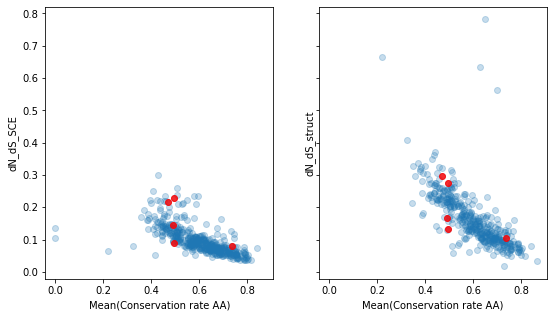

In [17]:
#Plot dN/dS for structural vs Neilsen

struct_data_dnds = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_struct_neilsen.csv'))

fig, axarr = plt.subplots(1,2, figsize=(9,5), sharex=True, sharey = True)
dnds_seq_cols = [ 'dN_dS_SCE', 'dN_dS_struct']

for jj, dnds_seq_col in enumerate(dnds_seq_cols):   
    ax = axarr[jj]
    ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds[dnds_seq_col], alpha = 0.25)
    ax.set_ylabel(dnds_seq_col)
    ax.set_xlabel('Mean(Conservation rate AA)')
    
    struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]
    
    ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset[dnds_seq_col],color='r' ,alpha = 0.8)
    ax.set_ylabel(dnds_seq_col)
    ax.set_xlabel('Mean(Conservation rate AA)')
    

In [ ]:
Difference between structural and sequence and Conservation rate.  
    Improvement 
    
Parse based on structural regions.  

In [110]:
struct_data_dnds[struct_data_dnds['dN_dS_struct']>0.35]

,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
51,OG1115,OG1115_REF_Scer_AF-P06208-F1-model_v2,0.816146,0.699453,0.792947,NaN,NaN,OG1115.out_yn00,0.07050,0.56150,0.50180,0.91650,OG1115
175,OG1640,OG1640_REF_Scer_AF-P23501-F1-model_v2,0.777894,0.438573,0.628229,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035,0.37080,0.71020,1.89560,OG1640
188,OG1603,OG1603_REF_Scer_AF-P25632-F1-model_v2,0.483782,0.219630,0.341672,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,0.66540,1.70570,2.56350,OG1603
195,OG1364,OG1364_REF_Scer_AF-P27796-F1-model_v2,0.875985,0.627606,0.745329,OG1364.out_yn00,0.0892,OG1364.out_yn00,0.10130,0.63280,0.54450,0.89970,OG1364
203,OG1230,OG1230_REF_Scer_AF-P29465-F1-model_v2,0.656116,0.647399,0.771185,OG1230.out_yn00,0.0741,OG1230.out_yn00,0.07645,0.78170,1.83330,2.33980,OG1230
289,OG3242,OG3242_REF_Scer_AF-P38179-F1-model_v2,0.810937,0.434906,0.639977,OG3242.out_yn00,0.1586,OG3242.out_yn00,0.23930,0.36230,0.75585,1.96445,OG3242
347,OG1254,OG1254_REF_Scer_AF-P40395-F1-model_v2,0.606233,0.322243,0.520691,OG1254.out_yn00,0.0807,OG1254.out_yn00,0.09200,0.40765,0.77905,2.04350,OG1254


In [ ]:
Has paralogs: 
    OG1115 (had dS > 50 )
    OG1603 (its paralog OG1603_REF_Scer_AF-P16120-F1-model_v2 failed dS filter)  #Check to see if I included the C0 clusters .  This one has a Pombe and a Sc cluster
    OG1640


No paralogs 
OG1364 (had dS > 50)
OG1230 
OG3242 (fairly high in both) 

In [112]:
struct_data_dnds[struct_data_dnds['og_x'].isin(struct_data_dnds[struct_data_dnds['dN_dS_struct']>0.35]['og_x'])]

,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
51,OG1115,OG1115_REF_Scer_AF-P06208-F1-model_v2,0.816146,0.699453,0.792947,NaN,NaN,OG1115.out_yn00,0.07050,0.56150,0.50180,0.91650,OG1115
136,OG1603,OG1603_REF_Scer_AF-P16120-F1-model_v2,0.953019,0.673427,0.777066,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,NaN,NaN,NaN,OG1603
175,OG1640,OG1640_REF_Scer_AF-P23501-F1-model_v2,0.777894,0.438573,0.628229,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035,0.37080,0.71020,1.89560,OG1640
188,OG1603,OG1603_REF_Scer_AF-P25632-F1-model_v2,0.483782,0.219630,0.341672,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,0.66540,1.70570,2.56350,OG1603
195,OG1364,OG1364_REF_Scer_AF-P27796-F1-model_v2,0.875985,0.627606,0.745329,OG1364.out_yn00,0.0892,OG1364.out_yn00,0.10130,0.63280,0.54450,0.89970,OG1364
203,OG1230,OG1230_REF_Scer_AF-P29465-F1-model_v2,0.656116,0.647399,0.771185,OG1230.out_yn00,0.0741,OG1230.out_yn00,0.07645,0.78170,1.83330,2.33980,OG1230
289,OG3242,OG3242_REF_Scer_AF-P38179-F1-model_v2,0.810937,0.434906,0.639977,OG3242.out_yn00,0.1586,OG3242.out_yn00,0.23930,0.36230,0.75585,1.96445,OG3242
347,OG1254,OG1254_REF_Scer_AF-P40395-F1-model_v2,0.606233,0.322243,0.520691,OG1254.out_yn00,0.0807,OG1254.out_yn00,0.09200,0.40765,0.77905,2.04350,OG1254
383,OG1640,OG1640_REF_Scer_AF-P47013-F1-model_v2,0.776284,0.447742,0.627233,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035,NaN,NaN,NaN,NaN
455,OG1254,OG1254_REF_Scer_AF-Q01519-F1-model_v2,0.730381,0.537493,0.664542,OG1254.out_yn00,0.0807,OG1254.out_yn00,0.09200,0.08310,0.19410,2.77810,OG1254


In [113]:
selected_og_refs = ['OG4150_REF_Scer_AF-P07256-F1-model_v2', 'OG2603_REF_Scer_AF-P50076-F1-model_v2', 'OG2845_REF_Scer_AF-P43577-F1-model_v2', 'OG3677_REF_Scer_AF-P47125-F1-model_v2', 'OG1299_REF_Scer_AF-P00549-F1-model_v2']
selected_ogs = [og_ref.split('_')[0] for og_ref in selected_og_refs]
struct_data_dnds[struct_data_dnds['og_x'].isin(selected_ogs)]

,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
13,OG1299,OG1299_REF_Scer_AF-P00549-F1-model_v2,0.974529,0.735859,0.828039,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723,0.1063,0.15790,1.49275,OG1299
64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,0.2826,0.2764,0.54320,1.81100,OG4150
374,OG2845,OG2845_REF_Scer_AF-P43577-F1-model_v2,0.897537,0.488116,0.615662,OG2845.out_yn00,0.1453,OG2845.out_yn00,0.1342,0.1672,0.34990,2.31910,OG2845
388,OG3677,OG3677_REF_Scer_AF-P47125-F1-model_v2,0.821292,0.494179,0.641265,OG3677.out_yn00,0.0904,OG3677.out_yn00,0.1178,0.1337,0.36390,2.56720,OG3677
405,OG2603,OG2603_REF_Scer_AF-P50076-F1-model_v2,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,0.2577,0.2975,0.65965,2.11475,OG2603
413,OG1299,OG1299_REF_Scer_AF-P52489-F1-model_v2,0.971635,0.637307,0.763982,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723,NaN,NaN,NaN,NaN
